<img src="Dau.png">

#### MASEF, University Paris-Dauphine 2021:   Bryan Delamour 

## Deep learning rough volatility

##### Reference: Deep Learning Volatility

B. Horvath, A. Muguruza, M. Tomas

#####  Reference : On deep calibration of (rough) stochastic volatility models

C. Bayer
B. Horvath
A. Muguruza
B. Stemper
M. Tomas


In [1]:
import numpy as np
from cmath import * 
import torch
import pickle
import os
from time import time 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from termcolor import colored
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Strikes x Maturities grid

In [2]:
strikes = np.arange(0.5,1.6,0.1)
maturities = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2])
S0=1


## Approximating the implied volatility surface


Learn the map $F^{*}(\theta)=\left\{\sigma_{B S}^{\mathcal{M}(\theta)}\left(T_{i}, k_{j}\right)\right\}_{i=1, j=1}^{n,m} {\text {via a neural network }} \widetilde{F}(\theta):=F(\theta, \hat{w})$ where

$$
\begin{aligned}
F^{*}: \Theta & \longrightarrow \mathbb{R}^{n \times m} \\
\theta & \mapsto F^{*}(\theta)
\end{aligned}
$$

where the input is a parameter combination $\theta \in \Theta$ of the rough Bergomi model and the output is a $n \times m$ grid on the implied volatility surface $\left\{\sigma_{B S}^{\mathcal{M}(\theta)}\left(T_{i}, k_{j}\right)\right\}_{i=1, j=1}^{n,m}$

### Objective function

$$\hat{w}=\underset{w}{\operatorname{argmin}} \sum_{u=1}^{N_{T r a i n}} \sum_{i=1}^{n} \sum_{j=1}^{m}\left(F\left(\theta_{u}, w\right)_{i j}-F^{*}\left(\theta_{u}\right)_{i j}\right)^{2}$$

$\hat{w}$ is the optimal network's weights.

## Neural network architecture

1. A fully connected feed forward neural network with 3 hidden layers and 30 nodes on each layers;
2. Input dimension $= 4$, number of model parameters
3. Output dimension $=11$ strikes $\times 8$ maturities for this experiment, but this choice of grid can be enriched or modified.
4. The three inner layers have 30 nodes each, which adding the corresponding biases results on a number

$$
(4+1) \times 30+3 \times(1+30) \times 30+(30+1) \times 88=30\times 4+5548 = 5668
$$


5. We choose the Elu $\sigma_{\text {Elu }}=\alpha\left(e^{x}-1\right)$ activation function for the network.

<img src="NN_pic.png">

### Layer's initialization

Suppose $w_{i j}^{(l)}$ denotes the weight of node $i, 1 \leq i \leq n_{l}$ in layer $1 \leq l \leq L$ being multiplied with the output of node $j, 1 \leq j \leq n_{l-1}$ in layer $l-1$ and $n_{0}$ denotes the number of network inputs. He et al. (2015) suggest the weights and biases be independently drawn as follows

$$
w_{i j}^{(l)} \sim \mathcal{N}\left(0, \frac{2}{n_{l-1}}\right), \quad b_{i}^{(l)}=0
$$

##### Reference: Deep calibration of rough stochastic volatility models
C. Bayer, B. Stemper

In [3]:
# Fully connected Neural Network with:

    # Elu activation (alpha=1)
    # 3 hidden Layers
    # 30 nodes

hidden_dim = 30
input_dim = 4 # xi, nu, rho, H 
output_dim = 11*8 # 11x8 IV surface


class NN_IV(nn.Module):
    def __init__(self):
        
        super(NN_IV, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)

        self.hidden_layer1 = nn.Linear(hidden_dim, hidden_dim)

        self.hidden_layer2 = nn.Linear(hidden_dim, hidden_dim)

        self.hidden_layer3 = nn.Linear(hidden_dim, hidden_dim)

        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
        self.elu = nn.ELU(alpha=1, inplace=False)
    
# WEIGHTS INITIALIZATION 
        for name, param in self.input_layer.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=2/(input_dim))
                
        for name, param in self.hidden_layer1.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=2/(input_dim))
                
        for name, param in self.hidden_layer2.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=2/(hidden_dim)) 
                
        for name, param in self.hidden_layer3.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=2/(hidden_dim))
                
                
        for name, param in self.output_layer.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=2/(hidden_dim))    

# Feedforward 
    def forward(self, rBergomi_parameters):
                
        input_layer = self.input_layer(rBergomi_parameters)
        
        hidden_layer1 = self.hidden_layer1(input_layer)
        activation1 = self.elu(hidden_layer1)
        
        hidden_layer2 = self.hidden_layer2(activation1)
        activation2 = self.elu(hidden_layer2)
        
        hidden_layer3 = self.hidden_layer3(activation2)
        activation3 = self.elu(hidden_layer3)
        
        output = self.output_layer(activation3)
        
        
        return (output)


In [4]:
# Function to count network's parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [5]:
# Model summary

NN_iv = NN_IV()
print(NN_iv)

print("Number of parameters", count_parameters(NN_IV()))


NN_IV(
  (input_layer): Linear(in_features=4, out_features=30, bias=True)
  (hidden_layer1): Linear(in_features=30, out_features=30, bias=True)
  (hidden_layer2): Linear(in_features=30, out_features=30, bias=True)
  (hidden_layer3): Linear(in_features=30, out_features=30, bias=True)
  (output_layer): Linear(in_features=30, out_features=88, bias=True)
  (elu): ELU(alpha=1)
)
Number of parameters 5668


## Loading iv surfaces and rBergomi parameters

In [6]:
# Data importation

iv_training_File = "iv_training_data.pkl" 
model_parameters_training_File = "model_parameters_training_data.pkl" 

with open(iv_training_File, 'rb') as file:  
    implied_vols = pickle.load(file)
    
with open(model_parameters_training_File, 'rb') as file:  
    model_parameters = pickle.load(file)
    
XI = model_parameters[:,0]
NU = model_parameters[:,1]
RHO = model_parameters[:,2]
H = model_parameters[:,3]


### Normalization of model parameters

Usually, model parameters are restricted to a given domain i.e. $\theta \in\left[\theta_{\min }, \theta_{\max }\right]$. Then, we perform the following normalisation transform:

$$
\frac{2 \theta-\left(\theta_{\max }+\theta_{\min }\right)}{\theta_{\max }-\theta_{\min }} \in[-1,1]
$$

##### Reference: Deep Learning Volatility

B. Horvath, A. Muguruza, M. Tomas

In [7]:
# Normalization

param_max = np.array( [ 0.16, 4, -0.1, 0.5])
param_min = np.array( [0.01 , 0.3, -0.95, 0.025] )

model_parameters_N = (2*model_parameters - param_max - param_min)/ (param_max - param_min)


## Split training and test samples

In [8]:
# Split training and test

implied_vols_training =  torch.Tensor(implied_vols[:33792,:,:])
model_parameters_training =  torch.Tensor(model_parameters_N[:33792,:])

implied_vols_test =  torch.Tensor(implied_vols[34000:,:,:])
model_parameters_test =  torch.Tensor(model_parameters_N[34000:,:])


## Training procedure

### Adam minibatch training scheme


$w$ denotes the set of parameters - weights and biases $-$ of a neural network $F=F(w, x)$ Given parameters $0 \leq \beta_{1}, \beta_{2}<1, \epsilon, \alpha$, initial iterates $u_{0}:=0, v_{0}:=0, w_{0} \in \Omega$, the Adam scheme has the following iterates:


$$
\begin{aligned}
g_{n} &:=\nabla^{w} \sum_{i=1}^{m} \mathcal{L}\left(F\left(w_{n-1}, X_{n, m}^{\text {batch }}\right), F^{*}\left(X_{n, m}^{\text {batch }}\right)\right) \\
u_{n+1} &:=\beta_{1} u_{n}+\left(1-\beta_{1}\right) g_{n} \\
v_{n+1} &:=\beta_{2} v_{n}+\left(1-\beta_{2}\right) g_{n}^{2} \\
w_{n+1} &:=w_{n}-\alpha \frac{u_{n+1}}{1-\beta_{1}^{n+1}} \frac{1}{\sqrt{v_{n} /\left(1-\beta_{2}^{n+1}\right)}+\epsilon}
\end{aligned}
$$

#####  Reference : On deep calibration of (rough) stochastic volatility models

C. Bayer
B. Horvath
A. Muguruza
B. Stemper
M. Tomas


### Preventing overfitting

To prevent overfitting, between each epoch we sample new minibatches draw uniformly from the training set. This allows a better generalization of the network's solution. We will see its effect on the test set loss and the training set loss as both will follow the same decrease until the last epoch. The 'shuffle_batch' function below will therefore be used at the begining of each epoch.

In [9]:
def shuffle_batch(in_sample, out_sample, batch_size):
    rnd_idx = np.random.permutation(in_sample.shape[0])
    in_sample_batch = []
    out_sample_batch = []
    n_batches = in_sample.shape[0] // batch_size
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        in_sample_batch.append(in_sample[batch_idx,:])
        out_sample_batch.append(out_sample[batch_idx,:,:])
        
    return ( (in_sample_batch, out_sample_batch) )


### Rate decay

During the training, the solution provided by the network might come close to a local or global minimum, in this situation jumps in the loss can be seen and the loss won't be able to improve further. To prevent this situation we use a linear learning rate decay during starting at epoch 0, and decreasing until the last epoch.

The learning rate at epoch $k$:
$$
\epsilon_{k}=(1-\alpha) \epsilon_{0}+\alpha \epsilon_{\tau}
$$

with $\alpha=\frac{k}{\tau}$ ,
$\tau=200$.

##### Reference: Deep Learning
I. Goodfellow, Y. Bengio, A. Courville, Chapter 8

### Early stopping variant

We keep training the network until the last epoch, however we won't save the model unless the loss improved.

In fact, we will see that in our case the loss keeps improving until the last epoch.

### Training parameters

$\text{Batch size} = 256$

$\text{Number of epochs} = 200$

$ \text{Starting learning rate} = 5\times 10^{-3} $

$ \text{Ending learning rate} = 10^{-5} $

In [10]:
# Training setting 

learning_rate = 0.005  
batch_size = 256
epochs = 200
nb_batch = model_parameters_training.shape[0]//batch_size #nb of batch / set
optimizer = torch.optim.Adam(NN_iv.parameters(), lr=learning_rate)
loss = nn.MSELoss()


In [11]:
# At each epoch, saving test/training loss, and learning rates 

min_loss = 10
LOSS_B = []
LOSS_test = []
training_rates = [learning_rate]

# Saving the network

NN_iv_model_File = "NN_iv_model.pkl" 


In [12]:
# Rate decay

tau = 200 
min_rate = 0.01*learning_rate 


In [13]:
# Functions used to reshape network's output to a matrix

def vector(matrix):
    x = matrix[:,0,:]
    for i in range(1,matrix.shape[1]):
        x = torch.cat((x,matrix[:,i,:]), dim=1)
    return(x)

def matrix(vector,rows,colums):
    x = torch.zeros((vector.shape[0],rows,colums))
    for i in range(vector.shape[0]):
        for j in range(rows):
            x[i,j,:] = vector[i,j*colums:(j+1)*colums]
    return(x)


In [14]:
# Training

t1 = time()

for epoch in range(epochs):
    
    loss_b = 0
    
    in_sample_batch, out_sample_batch = shuffle_batch(model_parameters_training, implied_vols_training, batch_size)
    
    for in_sample, out_sample in zip(in_sample_batch, out_sample_batch) :

        optimizer.zero_grad()
        
        output = NN_iv(in_sample)
        
        out_sample = vector(out_sample)
        
        loss_batch = loss(output,out_sample)

        loss_b += loss_batch/nb_batch    
        
        loss_batch.backward()
        optimizer.step()
    
        min_loss = min(min_loss,loss_batch)
      
    LOSS_B.append(loss_b.item())
        
    output = NN_iv(model_parameters_test)
    
    out_test = vector(implied_vols_test)
    test = loss(output,out_test)
    LOSS_test.append(test)
    
    if (test<=min(LOSS_test)):
        with open(NN_iv_model_File, 'wb') as file:  
            pickle.dump(NN_iv, file)      
    
    print(colored("Epoch:",'red'), epoch,colored("Training Loss:",'red'), colored(loss_b.item(),'red') )
    print(colored("Test Loss ", 'green'), colored(test.item(),'green'))
    print("Current Learning Rate", training_rates[-1] )
    print( "Best Training Loss", min(LOSS_B))
    print('Best Batch Loss',min_loss.item()) 
    print("Min Test Loss", min(LOSS_test).item(), '\n')
 
    if (epoch<tau):
        rate = (1-(epoch/tau))*learning_rate + (epoch/tau)*min_rate 
        optimizer.param_groups[0]['lr'] = rate
        training_rates.append(rate)
      
    else:
        rate = min_rate 
        optimizer.param_groups[0]['lr'] = rate
        training_rates.append(rate)

t2 = time()


Epoch: 0 Training Loss: 0.003782991785556078
Test Loss  0.00018598181486595422
Current Learning Rate 0.005
Best Training Loss 0.003782991785556078
Best Batch Loss 0.0001705485483398661
Min Test Loss 0.00018598181486595422 

Epoch: 1 Training Loss: 0.00014766448293812573
Test Loss  0.00011598105629673228
Current Learning Rate 0.005
Best Training Loss 0.00014766448293812573
Best Batch Loss 9.711121674627066e-05
Min Test Loss 0.00011598105629673228 

Epoch: 2 Training Loss: 0.00010515582107473165
Test Loss  8.688740490470082e-05
Current Learning Rate 0.0049752500000000005
Best Training Loss 0.00010515582107473165
Best Batch Loss 6.573811697307974e-05
Min Test Loss 8.688740490470082e-05 

Epoch: 3 Training Loss: 8.186290506273508e-05
Test Loss  6.93247202434577e-05
Current Learning Rate 0.0049505
Best Training Loss 8.186290506273508e-05
Best Batch Loss 5.5952728871488944e-05
Min Test Loss 6.93247202434577e-05 

Epoch: 4 Training Loss: 6.775074143661186e-05
Test Loss  6.27775807515718e-05
C

Epoch: 30 Training Loss: 3.3928215998457745e-05
Test Loss  2.8138152629253455e-05
Current Learning Rate 0.0042822500000000005
Best Training Loss 3.178830957040191e-05
Best Batch Loss 1.746388261381071e-05
Min Test Loss 2.6102496121893637e-05 

Epoch: 31 Training Loss: 3.147120514768176e-05
Test Loss  2.8544953238451853e-05
Current Learning Rate 0.0042575
Best Training Loss 3.147120514768176e-05
Best Batch Loss 1.557845826027915e-05
Min Test Loss 2.6102496121893637e-05 

Epoch: 32 Training Loss: 2.9355340302572586e-05
Test Loss  3.275681228842586e-05
Current Learning Rate 0.0042327499999999995
Best Training Loss 2.9355340302572586e-05
Best Batch Loss 1.557845826027915e-05
Min Test Loss 2.6102496121893637e-05 

Epoch: 33 Training Loss: 3.1511499400949106e-05
Test Loss  2.5965327949961647e-05
Current Learning Rate 0.004208
Best Training Loss 2.9355340302572586e-05
Best Batch Loss 1.557845826027915e-05
Min Test Loss 2.5965327949961647e-05 

Epoch: 34 Training Loss: 3.0524162866640836e-05
T

Epoch: 59 Training Loss: 2.3124383005779237e-05
Test Loss  2.2057583919377066e-05
Current Learning Rate 0.0035645
Best Training Loss 2.3124383005779237e-05
Best Batch Loss 1.1002359315170906e-05
Min Test Loss 2.1601397747872397e-05 

Epoch: 60 Training Loss: 2.2516618628287688e-05
Test Loss  2.1188865503063425e-05
Current Learning Rate 0.0035397500000000004
Best Training Loss 2.2516618628287688e-05
Best Batch Loss 1.0077314072987065e-05
Min Test Loss 2.1188865503063425e-05 

Epoch: 61 Training Loss: 2.3933187549118884e-05
Test Loss  2.458290873619262e-05
Current Learning Rate 0.0035149999999999995
Best Training Loss 2.2516618628287688e-05
Best Batch Loss 1.0077314072987065e-05
Min Test Loss 2.1188865503063425e-05 

Epoch: 62 Training Loss: 2.2596639610128477e-05
Test Loss  2.0609180864994414e-05
Current Learning Rate 0.0034902500000000003
Best Training Loss 2.2516618628287688e-05
Best Batch Loss 1.0077314072987065e-05
Min Test Loss 2.0609180864994414e-05 

Epoch: 63 Training Loss: 2.23

Epoch: 88 Training Loss: 1.9999404685222544e-05
Test Loss  1.8053289750241674e-05
Current Learning Rate 0.00284675
Best Training Loss 1.9598093786044046e-05
Best Batch Loss 8.345852620550431e-06
Min Test Loss 1.8053289750241674e-05 

Epoch: 89 Training Loss: 1.9589388102758676e-05
Test Loss  1.9429777239565738e-05
Current Learning Rate 0.0028220000000000003
Best Training Loss 1.9589388102758676e-05
Best Batch Loss 8.345852620550431e-06
Min Test Loss 1.8053289750241674e-05 

Epoch: 90 Training Loss: 1.961471207323484e-05
Test Loss  1.8753977201413363e-05
Current Learning Rate 0.00279725
Best Training Loss 1.9589388102758676e-05
Best Batch Loss 8.345852620550431e-06
Min Test Loss 1.8053289750241674e-05 

Epoch: 91 Training Loss: 1.8683616872294806e-05
Test Loss  1.8167405869462527e-05
Current Learning Rate 0.0027725000000000002
Best Training Loss 1.8683616872294806e-05
Best Batch Loss 8.345852620550431e-06
Min Test Loss 1.8053289750241674e-05 

Epoch: 92 Training Loss: 1.9101147699984722

Epoch: 117 Training Loss: 1.712590346869547e-05
Test Loss  1.623365460545756e-05
Current Learning Rate 0.0021290000000000002
Best Training Loss 1.712590346869547e-05
Best Batch Loss 7.061269116093172e-06
Min Test Loss 1.6067890101112425e-05 

Epoch: 118 Training Loss: 1.736465492285788e-05
Test Loss  1.6043861251091585e-05
Current Learning Rate 0.0021042500000000002
Best Training Loss 1.712590346869547e-05
Best Batch Loss 7.061269116093172e-06
Min Test Loss 1.6043861251091585e-05 

Epoch: 119 Training Loss: 1.7395337636116892e-05
Test Loss  1.574094312672969e-05
Current Learning Rate 0.0020795
Best Training Loss 1.712590346869547e-05
Best Batch Loss 7.061269116093172e-06
Min Test Loss 1.574094312672969e-05 

Epoch: 120 Training Loss: 1.7033982658176683e-05
Test Loss  1.63846489158459e-05
Current Learning Rate 0.00205475
Best Training Loss 1.7033982658176683e-05
Best Batch Loss 7.061269116093172e-06
Min Test Loss 1.574094312672969e-05 

Epoch: 121 Training Loss: 1.7295733414357528e-05
T

Epoch: 146 Training Loss: 1.554046139062848e-05
Test Loss  1.5276751582860015e-05
Current Learning Rate 0.0014112500000000002
Best Training Loss 1.554046139062848e-05
Best Batch Loss 6.145982297312003e-06
Min Test Loss 1.4793386981182266e-05 

Epoch: 147 Training Loss: 1.5426929167006165e-05
Test Loss  1.4861549061606638e-05
Current Learning Rate 0.0013865000000000001
Best Training Loss 1.5426929167006165e-05
Best Batch Loss 6.145982297312003e-06
Min Test Loss 1.4793386981182266e-05 

Epoch: 148 Training Loss: 1.5537150829914026e-05
Test Loss  1.4953253412386402e-05
Current Learning Rate 0.0013617500000000001
Best Training Loss 1.5426929167006165e-05
Best Batch Loss 6.145982297312003e-06
Min Test Loss 1.4793386981182266e-05 

Epoch: 149 Training Loss: 1.575904207129497e-05
Test Loss  1.4929847566236276e-05
Current Learning Rate 0.001337
Best Training Loss 1.5426929167006165e-05
Best Batch Loss 6.145982297312003e-06
Min Test Loss 1.4793386981182266e-05 

Epoch: 150 Training Loss: 1.5379

Epoch: 175 Training Loss: 1.4460123566095717e-05
Test Loss  1.4037725122761913e-05
Current Learning Rate 0.0006935000000000001
Best Training Loss 1.4460123566095717e-05
Best Batch Loss 5.620930096483789e-06
Min Test Loss 1.4037725122761913e-05 

Epoch: 176 Training Loss: 1.4360953173309099e-05
Test Loss  1.3985732948640361e-05
Current Learning Rate 0.00066875
Best Training Loss 1.4360953173309099e-05
Best Batch Loss 5.620930096483789e-06
Min Test Loss 1.3985732948640361e-05 

Epoch: 177 Training Loss: 1.4276251022238284e-05
Test Loss  1.3993593711347785e-05
Current Learning Rate 0.0006439999999999999
Best Training Loss 1.4276251022238284e-05
Best Batch Loss 5.2103687266935594e-06
Min Test Loss 1.3985732948640361e-05 

Epoch: 178 Training Loss: 1.421547494828701e-05
Test Loss  1.3827619113726541e-05
Current Learning Rate 0.00061925
Best Training Loss 1.421547494828701e-05
Best Batch Loss 5.2103687266935594e-06
Min Test Loss 1.3827619113726541e-05 

Epoch: 179 Training Loss: 1.4258072951

## Loss evolution during training

The test sample loss (green) is computed at each epoch, however the network's weights are not updated according to this loss. 

It illustrates how well the network's solution generalizes to unseen data, and allows us to check for overfitting and learning rates adjustment.

Finale Validation Loss 1.3493269761966076e-05
Best Validation Loss 1.3493269761966076e-05
Finale Test Loss 1.3326070074981544e-05
Best Test Loss 1.329455972154392e-05
Data Size torch.Size([33792, 4])
Training Time (h) 0.029689120848973592 

Quadratic loss evolution during training


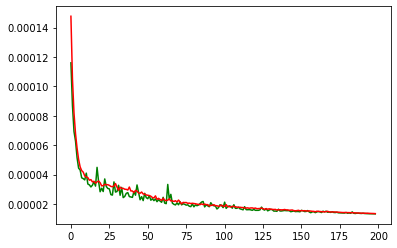

Learning rates evolution during training


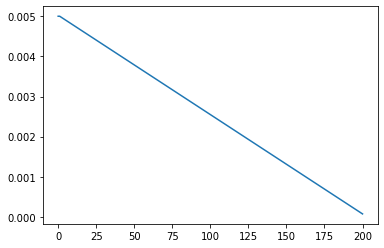

In [15]:
print( colored('Finale Validation Loss','red') , colored(loss_b.item(),'red'))
print( colored('Best Validation Loss', 'green'), min(LOSS_B))
print(colored('Finale Test Loss', 'red'), LOSS_test[-1].item())
print(colored('Best Test Loss', 'green' ), min(LOSS_test).item() )
print('Data Size', model_parameters_training.shape)
print("Training Time (h)", (t2-t1)/3600 ,'\n') 




print( "Quadratic loss evolution during training")
plt.plot(LOSS_test[1:],color='green')
plt.plot(LOSS_B[1:],color='red')
plt.show()

print("Learning rates evolution during training")
plt.plot(training_rates)
plt.show()


### Illustration of the neural network's output

We will illustrate some true implied volatility surface against the neural network approximation, using test samples, ie, samples which have not be used to calibrate the network's weights.

We can see that true surfaces and surfaces generated by the network using the corresponding rough Bergomi parameters are indistinguishable by the eye.

In [16]:
def surface_plot (matrix, **kwargs):
    (x, y) = np.meshgrid(strikes,maturities)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

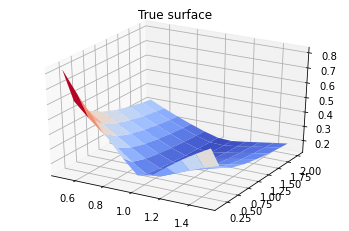

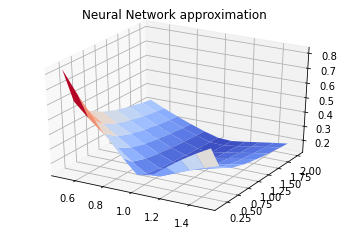

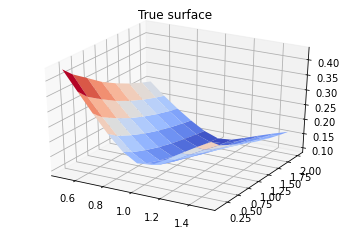

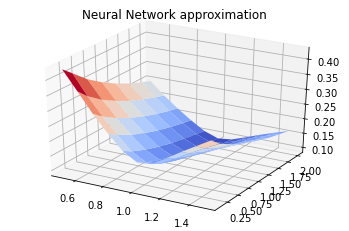

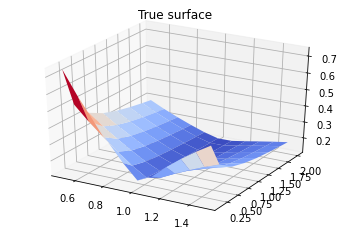

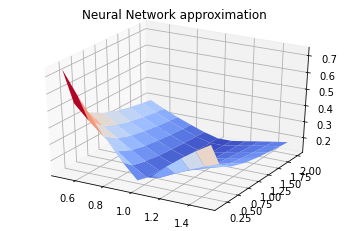

In [17]:
output = matrix(NN_iv(model_parameters_test),11,8)
out_test = implied_vols_test

for i in range(3):
    
    rd = 100 # choose 
    
    iv_true = out_test[i+rd,:,:].detach().numpy().T
    (fig, ax, surf) = surface_plot(iv_true, cmap=plt.cm.coolwarm)
    ax.set_title('True surface')
 
    iv = output[i+rd,:,:].detach().numpy().T
    (fig, ax, surf) = surface_plot(iv, cmap=plt.cm.coolwarm)
    ax.set_title('Neural Network approximation')

## Accuracy of the IV map as learned by the network

### Relative Error

We compare surface relative errors of the neural network approximator against the Monte Carlo benchmark across all training data.

Relative error here is computed as 
$$\frac{\left|\sigma^{N N}(T, k)-\sigma^{M C}(T, k)\right|}{\left|\sigma^{M C}(T, k)\right|}
$$

In [18]:
def average_RE(pred, true):
    return (torch.mean( abs(pred-true)/(true) , dim=0))

def RE(pred,true):
    return( abs(pred-true)/(true) )

def std_RE(pred, true):
    return (torch.std( abs(pred-true)/(true) , dim=0) )

def max_RE(pred, true):
    return(torch.max( abs(pred-true)/(true) , dim=0)[0])

### Relative error heatmap

In [19]:
a_relative_error = average_RE(output, implied_vols_test)
std_ = std_RE(output, implied_vols_test)
max_ = max_RE(output, implied_vols_test)

Average of the relative error across all maturities and strikes: 0.0045959763


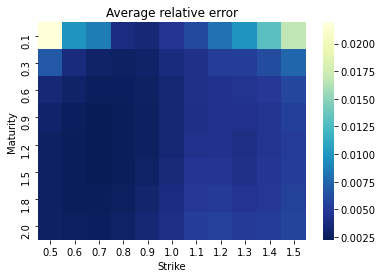

Average of the std relative error across all maturities and strikes: 0.0070257606


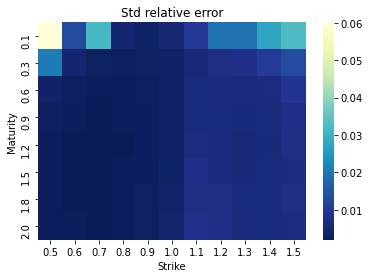

Average of the maximum relative error across all maturities and strikes: 0.14148127


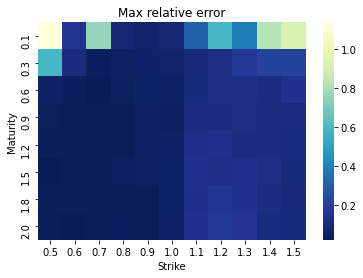

In [20]:
print("Average of the relative error across all maturities and strikes:", np.mean(a_relative_error.detach().numpy().T))
heat = sns.heatmap(a_relative_error.detach().numpy().T, xticklabels=np.round(strikes,1), yticklabels=np.round(maturities,1), cmap="YlGnBu_r")
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title('Average relative error')
plt.show()

print("Average of the std relative error across all maturities and strikes:", np.mean(std_.detach().numpy().T))
heat = sns.heatmap(std_.detach().numpy().T, xticklabels=np.round(strikes,1), yticklabels=np.round(maturities,1), cmap="YlGnBu_r")
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title('Std relative error')
plt.show()

print("Average of the maximum relative error across all maturities and strikes:", np.mean(max_.detach().numpy().T))
heat = sns.heatmap(max_.detach().numpy().T, xticklabels=np.round(strikes,1), yticklabels=np.round(maturities,1), cmap="YlGnBu_r")
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title('Max relative error')
plt.show()

### Relative error distribution

In [21]:
relative_error = RE(output, implied_vols_test)
relative_error = torch.reshape(relative_error, (6000*88,1))
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error.detach().numpy()))]
q_95 = sorted_re[int(0.95*len(relative_error.detach().numpy()))]
q_99 = sorted_re[int(0.99*len(relative_error.detach().numpy()))]

quantile 90% =  0.00914048869162798
quantile 95% =  0.013742786832153797
quantile 99% =  0.034383561462163925


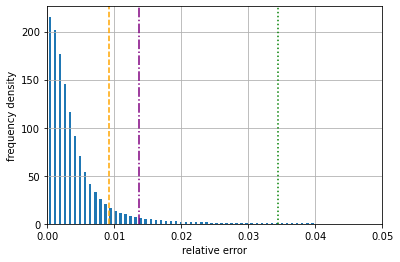

In [22]:
print('quantile 90% = ', q_90.item())
print('quantile 95% = ', q_95.item())
print('quantile 99% = ', q_99.item())
plt.hist(relative_error.detach().numpy(), bins=np.linspace(0, 0.15, 200), density=True, rwidth=0.5)
plt.xlim((0, 0.05))


plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange')
plt.axvline(x=q_95, ls='-.', color='purple')
plt.axvline(x=q_99, ls=':', color='green')
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()
